In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from category_encoders import TargetEncoder, CountEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, accuracy_score

In [2]:
# load the parquet file
df = pd.read_parquet('dataset/train-500k.parquet')
df['hour'] = pd.to_datetime(df['hour'], format='%y%m%d%H')
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,2014-10-21,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


### Encoding Features

First, I am going to define the threshold for low, moderate, and high cardinality features based on the number of unique values in `['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_model']`.

In [3]:
columns = [
  'site_id', 'site_domain', 'site_category', 
  'app_id', 'app_domain', 'app_category', 
  'device_model'
]

low_cardinality_threshold = 100
moderate_cardinality_threshold = 1000

I then preprocess each categorical feature based on its cardinality:
1. Apply one-hot encoding to features with low-cardinality (num_of_features < 100)
2. Apply frequency encoding to features with moderate-cardinality (100 < num_of_features < 1000)
3. Apply target encoding to features with high-cardinality (num_of_features > 1000)

In [4]:
df_processed = df.copy()
df_processed['time_of_day'] = df_processed['hour'].dt.hour

for col in columns:
  unique_values_count = df[col].nunique()
  
  if unique_values_count < low_cardinality_threshold:
    # Low cardinality: Apply one-hot encoding
    df_processed = pd.concat([df_processed, pd.get_dummies(df[col], prefix=col)], axis=1)
    df_processed.drop(columns=[col], inplace=True)
  elif low_cardinality_threshold <= unique_values_count < moderate_cardinality_threshold:
    # Moderate cardinality: Apply frequency encoding
    encoder = CountEncoder()
    df_processed[col] = encoder.fit_transform(df[col])
  else:
    # High cardinality: Apply target encoding
    encoder = TargetEncoder()
    df_processed[col] = encoder.fit_transform(df[col], df['click'])

df_processed.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,app_id,app_domain,device_id,...,app_category_8ded1f7a,app_category_8df2e842,app_category_a3c42688,app_category_a7fd01ec,app_category_a86a3e89,app_category_cef3e649,app_category_d1327cf5,app_category_dc97ec06,app_category_f95efa07,app_category_fc6fa53d
0,1.000009e+18,0,2014-10-21,1005,0,0.211825,0.211825,0.196176,366566,a99f214a,...,False,False,False,False,False,False,False,False,False,False
1,1.000017e+19,0,2014-10-21,1005,0,0.211825,0.211825,0.196176,366566,a99f214a,...,False,False,False,False,False,False,False,False,False,False
2,1.000037e+19,0,2014-10-21,1005,0,0.211825,0.211825,0.196176,366566,a99f214a,...,False,False,False,False,False,False,False,False,False,False
3,1.000064e+19,0,2014-10-21,1005,0,0.211825,0.211825,0.196176,366566,a99f214a,...,False,False,False,False,False,False,False,False,False,False
4,1.000068e+19,0,2014-10-21,1005,1,0.035931,0.035931,0.196176,366566,a99f214a,...,False,False,False,False,False,False,False,False,False,False


# Training

In this part, we are going to train the data with numerous algorithms like:
1. Logistic Regression
2. Principal Component Analysis (PCA) and Latent Dirichlet Allocation (LDA)

Since we are going to feed the data into some of this algorithms, it's best to normalize our data for the following reasons:
1. Enhancing interpretability coefficients produced
2. Stabilizing numerical calculations, meaning little changes won't affect predictions significantly
3. Avoiding dominance of certain features/columns
4. Speedup convergence speed

In [5]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 64 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      500000 non-null  float64       
 1   click                   500000 non-null  int64         
 2   hour                    500000 non-null  datetime64[ns]
 3   C1                      500000 non-null  int64         
 4   banner_pos              500000 non-null  int64         
 5   site_id                 500000 non-null  float64       
 6   site_domain             500000 non-null  float64       
 7   app_id                  500000 non-null  float64       
 8   app_domain              500000 non-null  int64         
 9   device_id               500000 non-null  object        
 10  device_ip               500000 non-null  object        
 11  device_model            500000 non-null  float64       
 12  device_type             500000

Since the dataset only consists data of ads in a day in different hours, it's important to encode the hour when the ads were clicked.

In the visualization part, we have seen that time of the day matters especially in ads engagement probability.

In [6]:
object_columns = df_processed.select_dtypes(include=['object']).columns

excluded_columns = ['id', 'click', 'hour']
feature_columns = df_processed.columns.difference(excluded_columns).difference(object_columns)

Before splitting the dataset into the training set and the testing test, we have excluded `id`, `click`, and `hour` columns.

In [7]:
normalizer = Normalizer()
processed_df = normalizer.fit_transform(df_processed[feature_columns])
X_train, X_test, y_train, y_test = train_test_split(processed_df, df['click'], test_size=0.2, random_state=42)

## Logisitic Regression

The reason of using Logistic Regression is if an instance if an ad was predicted to be more than 50% to be clicked then it would be regarded as 1. Otherwise, 0. Thus Logistic Regression is very suitable for binary class prediction like the problem we are currently facing, Click Through Rate prediction.

First we are going to find the appropriate parameters for the Logistic Regression algorithm using `RandomizedSearchCV`.

In [8]:
param_grid = {
  'penalty': ['l2'],
  'C': [0.001, 0.01, 0.1, 1, 10],
  'solver': ['sag', 'saga'],
  'class_weight': [None, 'balanced'],
  'max_iter': [100, 500, 1000]
}

logreg = LogisticRegression()
logreg_cv = RandomizedSearchCV(logreg, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
logreg_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'class_weight': [None, 'balanced'],
                                        'max_iter': [100, 500, 1000],
                                        'penalty': ['l2'],
                                        'solver': ['sag', 'saga']},
                   scoring='roc_auc')

In [9]:
print(logreg_cv.best_params_)

{'solver': 'sag', 'penalty': 'l2', 'max_iter': 1000, 'class_weight': 'balanced', 'C': 10}


In [10]:
logreg = LogisticRegression(**logreg_cv.best_params_)
logreg.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', max_iter=1000, solver='sag')

We can also make a pipeline to make the processes more streamlined. I would love to add the encoding step into the pipeline. Due to variations of column types, I prefer that process to be outside the pipeline.

To be clear, I have tried using a pipeline. If I decided to do so, I had to split the dataset into batches. Otherwise, the Python Kernel will crash due to the size of the data loaded into my computer's RAM.

```python
pipeline = make_pipeline(
  Normalizer(),
  LogisticRegression()
)

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)
```

```markdown
The Kernel crashed while executing code in the current cell or a previous cell. 
Please review the code in the cell(s) to identify a possible cause of the failure. 
Click here for more info. 
View Jupyter log for further details.
```

In [11]:
logreg.score(X_test, y_test)

0.42146

Let's print out the end values of intercept and coefficients.

In [12]:
print(f"Intercept: {logreg.intercept_}")
print(f"Coefficients:\n{logreg.coef_}")

Intercept: [0.09792315]
Coefficients:
[[ 1.77786847e+01 -2.56943706e+00  1.98744517e+00  3.72647361e+01
   6.04614185e+00  4.39960445e-01 -1.02855041e+01 -6.97050182e-01
  -3.14845163e+01  1.58592924e-01  8.79010470e-05  1.69131994e-01
  -7.85219051e-04 -7.88259984e-06 -1.67313576e-04 -5.47984616e-03
  -8.72184826e-05 -6.56147738e-03 -1.23517886e-03 -1.84584048e-01
   3.02577864e-04  4.97167180e-05 -4.64001845e-04  7.79763005e-04
  -2.08749760e-01 -6.35747572e-02  6.97625414e-03  1.92681852e-01
  -3.88613171e-02  1.53032459e-01  3.15638292e-01  6.29122768e-02
  -6.70772144e-01  1.79812079e-01 -1.52280217e-01 -1.41836034e-02
  -7.87332561e-06  1.24130175e-01 -1.40105147e-02  3.79485422e-02
   8.53562403e-05 -1.21503652e-01 -3.56648930e-05 -1.57899133e-03
  -3.71870700e-03 -2.21776916e-03 -3.20894288e-02 -2.13136921e-05
  -1.58182295e-05 -5.69295130e-04 -7.89944401e-05 -1.80485916e-04
  -1.40327835e-04 -2.14286949e-05  6.31201847e-02 -1.68654268e-02
   2.07172415e-01  2.14709736e-01 -1.8

In the question, it says to evaluate the model using the Logarithmic Loss method.

$$
\text{loss} = -\frac{1}{N} \sum_{i=1}^{N} y_i \cdot \log(p(y_i) + (1 - y_i) \cdot \log(1 - p(y_i))
$$

The smaller the value, the better.

In [13]:
predictions = logreg.predict(X_test)
log_loss(y_test, predictions)

20.85269523173983

However, with Logistic Regression and the log loss we got above, we are far away from perfect. Let's see what is the F1 score of our model.

In [14]:
print(f"F1 score: {f1_score(y_test, predictions)}")

F1 score: 0.3097005130652667


In [15]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
print(f"ROC-AUC score: {roc_auc_score(y_test, y_pred_prob)}")

ROC-AUC score: 0.5904331496011663


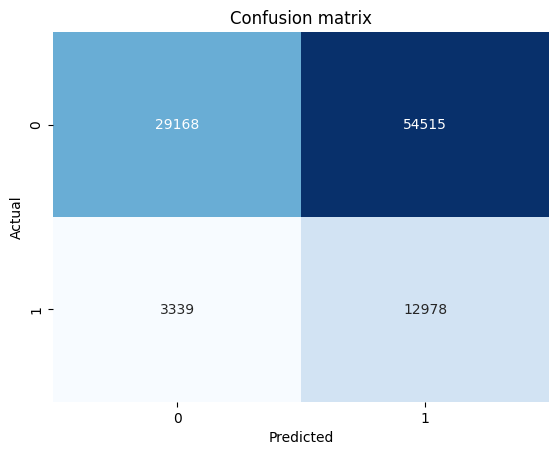

In [16]:
# plot the confusion matrix


conf_mat = confusion_matrix(y_test, predictions)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

From the graph above, we can see that the number of True Negative instances is $29,048$ and the number of True Positive instances is $12,997$.

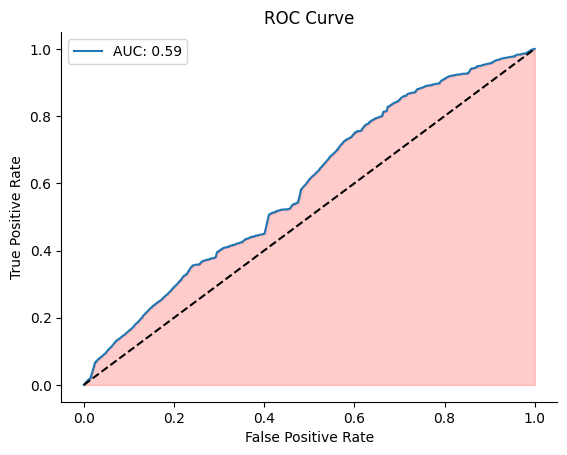

In [17]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'AUC: {roc_auc_score(y_test, y_pred_prob):.2f}')
plt.fill_between(fpr, tpr, alpha=0.2, color='r')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
sns.despine()
plt.legend()
plt.show()

In the graph above, we can see there are two lines: the blue represents the Receiver Operating Characteristic (ROC) line and the black one represents True Positive Rate = False Positive Rate. What blue line really or ROC represents is that the True Positive vs. False Positive rate at every decision threshold value.

Moreover, the x axis represents False Positive Rate, or $(1 - \text{Specificity})$ and the y axis represents True Positive Rate, or $\text{Sensitivity}$.

$$
1 - \text{Specificity} = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}
$$

$$
\text{Sensitivity} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

Ideally for the ROC curve, we want the blue line to approaches the top-left corner of the graph as it indicates the number of incorrectly classified instances decreases. However in this case, the blue line is very close to the dashed black line, that indicates that there were many occurences that were predicted wrong.

## Principal Component Analysis (PCA) and Latent Dirichlet Allocation (LDA)

Since we are working on a high-dimensional data. In our case, 59 features, or we can say 59 dimensions. In other words, our data is suffering from the "curse of dimensionality", meaning that as the number of dimensions increases, the amount of time to effectively train the data also increases, leading to potential overfitting.

So, what PCA has to do with LDA? By applying PCA, we can reduce the number of dimensions by retaining columns / dimensions / Principal Components (PC) that are high in Explained Variance Ratio (EVR). Once we get those PCs with high EVR in our dataset, we can use LDA to effectively separating each instance into into the correct class. In our case, we have two classes, will be clicked or not clicked.

The benefit of PCA + LDA? PCA will first remove noise and irrelevant features in our dataset. Thus, LDA can focus more on separating our data into appropriate classes, leading to better classification accuracy. Most importantly, lower-dimensional data are relatively cheaper to compute and faster for LDA to handle.

In [18]:
no_of_columns = feature_columns.shape[0]

In [19]:
pca = PCA(n_components=no_of_columns)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Remember, EVR stands for Explained Variance Ratio, and PC stands for Principal Components.

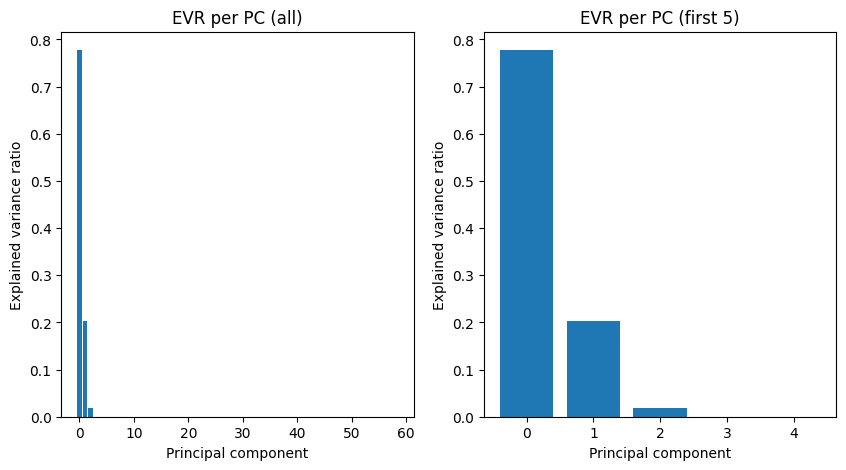

In [20]:
# 1 row and 2 columns for the subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].bar(range(no_of_columns), pca.explained_variance_ratio_)
ax[0].set_xlabel('Principal component')
ax[0].set_ylabel('Explained variance ratio')
ax[0].set_title('EVR per PC (all)')


ax[1].bar(range(5),pca.explained_variance_ratio_[:5])
ax[1].set_xlabel('Principal component')
ax[1].set_ylabel('Explained variance ratio')
ax[1].set_title('EVR per PC (first 5)')
plt.show()

In [21]:
# sort the columns by variance from highest to lowest
sorted_by_variance = sorted(zip(feature_columns, pca.explained_variance_ratio_), key=lambda x: x[1], reverse=True)

for col, variance in sorted_by_variance[:5]:
  print(f"{col}: {variance}")

C1: 0.777503867990405
C14: 0.2025841057271062
C15: 0.019507822471813697
C16: 0.0003520241436555018
C17: 4.780953691103399e-05


As we can see that, `C1` and `C14` combined explained $0.77 + 0.20 = 0.97$ of the variance of the entire data.

In [22]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_pca, y_train)
y_pred_lda = lda.predict(X_test_pca)

print(f"LDA accuracy: {accuracy_score(y_test, y_pred_lda)}")

LDA accuracy: 0.83259


Text(0.5, 1.0, 'LDA Confusion matrix')

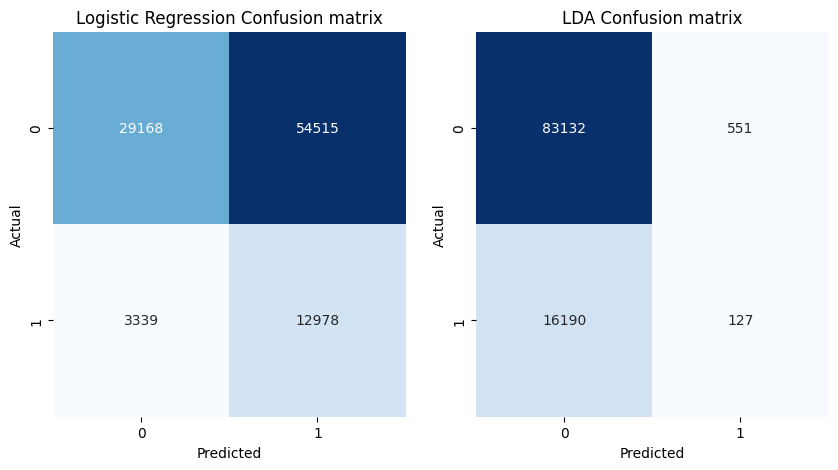

In [23]:
# plot the confusion matrix of Logistic Regression `conf_mat` and LDA side by side
conf_mat_lda = confusion_matrix(y_test, y_pred_lda)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_title('Logistic Regression Confusion matrix')

sns.heatmap(conf_mat_lda, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax[1])
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
ax[1].set_title('LDA Confusion matrix')

The figure above shows the new confusion matrix acquired from PCA + LDA. Now let's visualize the ROC-AUC graph of both confusion matrices from Logistic Regression and PCA + LDA.

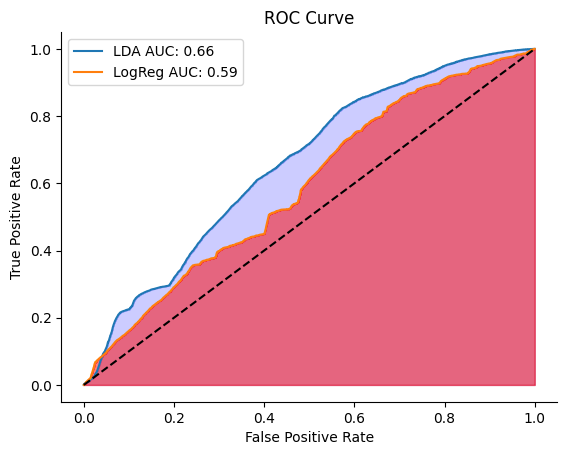

In [24]:
y_pred_prob_lda = lda.predict_proba(X_test_pca)[:,1]
fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_test, y_pred_prob_lda)

plt.plot(fpr_lda, tpr_lda, label=f'LDA AUC: {roc_auc_score(y_test, y_pred_prob_lda):.2f}')
plt.fill_between(fpr_lda, tpr_lda, alpha=0.2, color='b')
plt.plot(fpr, tpr, label=f'LogReg AUC: {roc_auc_score(y_test, y_pred_prob):.2f}')
plt.fill_between(fpr, tpr, alpha=0.5, color='r')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
sns.despine()
plt.legend()
plt.show()

Clearly, PCA + LDA produced a better ROC-AUC compared to Logistic Regression.